In [1]:
import gensim.downloader as api
import torch
from torch import nn
import pandas as pd
from collections import Counter

In [2]:
max_epochs = 10
batch_size = 256
sequence_length = 8

In [3]:
word2vec = api.load("glove-twitter-50")

In [4]:
word2idx = {word : idx for idx, word in enumerate(word2vec.index_to_key)}

In [5]:
def encoder(word):
    if word in word2idx.keys():
        return word2idx[word]
    return word2idx['unc']

In [6]:
def array_word2vec(arr):
    result = []
    for elem in arr:
        if elem not in word2vec:
            result.append(word2vec['unc'])
        else:
            result.append(word2vec[elem])
    return result

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
    ):
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()
        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}
        self.words_indexes = [self.word_to_index[w] for w in self.words]
    def load_words(self):
        train_df = pd.read_csv('train.csv')
        text = train_df['Joke'].str.cat(sep=' ')
        return text.split(' ')
    def get_uniq_words(self):
        common_df = pd.read_csv('common.csv')
        text = common_df['Joke'].str.cat(sep=' ')
        word_counts = Counter(text.split(' '))
        return sorted(word_counts, key=word_counts.get, reverse=True)
    def __len__(self):
        return len(self.words_indexes) - sequence_length
    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index:index+sequence_length]),
            torch.tensor(self.words_indexes[index+1:index+sequence_length+1]),
        )

In [8]:
class Dataset_test(torch.utils.data.Dataset):
    def __init__(
        self,
    ):
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()
        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}
        self.words_indexes = [self.word_to_index[w] for w in self.words]
    def load_words(self):
        train_df = pd.read_csv('test.csv')
        text = train_df['Joke'].str.cat(sep=' ')
        return text.split(' ')
    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)
    def __len__(self):
        return len(self.words_indexes) - sequence_length
    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index:index+sequence_length]),
            torch.tensor(self.words_indexes[index+1:index+sequence_length+1]),
        )

In [9]:
class simple_lstm(nn.Module):
    def __init__(self, dataset):
        super(simple_lstm, self).__init__()
        self.vector_size = word2vec.vector_size
        self.num_layers = 1
        n_vocab = len(dataset.uniq_words)
        self.embed = nn.Embedding(n_vocab, word2vec.vector_size)
        self.lstm = nn.LSTM(
            input_size=self.vector_size,
            hidden_size=self.vector_size,
            num_layers=self.num_layers,
        )
        self.fc = nn.Linear(self.vector_size, n_vocab)
    def forward(self, x, prev_state):
        embed = self.embed(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits
    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.vector_size),
                torch.zeros(self.num_layers, sequence_length, self.vector_size))

In [10]:
class simple_rnn(nn.Module):
    def __init__(self, dataset):
        super(simple_rnn, self).__init__()
        self.vector_size = word2vec.vector_size
        self.num_layers = 1
        n_vocab = len(dataset.uniq_words)
        self.embed = nn.Embedding(n_vocab, word2vec.vector_size)
        self.rnn = nn.RNN(
            input_size=self.vector_size,
            hidden_size=self.vector_size,
            num_layers=self.num_layers,
        )
        self.fc = nn.Linear(self.vector_size, n_vocab)
    def forward(self, x, prev_state):
        embed = self.embed(x)
        output = self.rnn(embed, prev_state[0])
        logits = self.fc(output[0])
        return logits
    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.vector_size),
                torch.zeros(self.num_layers, sequence_length, self.vector_size))

In [11]:
class simple_gru(nn.Module):
    def __init__(self, dataset):
        super(simple_gru, self).__init__()
        self.vector_size = word2vec.vector_size
        self.num_layers = 1
        n_vocab = len(dataset.uniq_words)
        self.embed = nn.Embedding(n_vocab, word2vec.vector_size)
        self.gru = nn.GRU(
            input_size=self.vector_size,
            hidden_size=self.vector_size,
            num_layers=self.num_layers,
        )
        self.fc = nn.Linear(self.vector_size, n_vocab)
    def forward(self, x, prev_state):
        embed = self.embed(x)
        output = self.gru(embed, prev_state[0])
        logits = self.fc(output[0])
        return logits
    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.vector_size),
                torch.zeros(self.num_layers, sequence_length, self.vector_size))

In [12]:
class lstm(nn.Module):
    def __init__(self, dataset):
        super(lstm, self).__init__()
        self.vector_size = word2vec.vector_size
        self.num_layers = 5
        n_vocab = len(dataset.uniq_words)
        self.embed = nn.Embedding(n_vocab, word2vec.vector_size)
        self.lstm = nn.LSTM(
            input_size=self.vector_size,
            hidden_size=self.vector_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.vector_size, n_vocab)
    def forward(self, x, prev_state):
        embed = self.embed(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits
    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.vector_size),
                torch.zeros(self.num_layers, sequence_length, self.vector_size))

In [13]:
class rnn(nn.Module):
    def __init__(self, dataset):
        super(rnn, self).__init__()
        self.vector_size = word2vec.vector_size
        self.num_layers = 5
        n_vocab = len(dataset.uniq_words)
        self.embed = nn.Embedding(n_vocab, word2vec.vector_size)
        self.rnn = nn.RNN(
            input_size=self.vector_size,
            hidden_size=self.vector_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.vector_size, n_vocab)
    def forward(self, x, prev_state):
        embed = self.embed(x)
        output = self.rnn(embed, prev_state[0])
        logits = self.fc(output[0])
        return logits
    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.vector_size),
                torch.zeros(self.num_layers, sequence_length, self.vector_size))

In [14]:
class gru(nn.Module):
    def __init__(self, dataset):
        super(gru, self).__init__()
        self.vector_size = word2vec.vector_size
        self.num_layers = 5
        n_vocab = len(dataset.uniq_words)
        self.embed = nn.Embedding(n_vocab, word2vec.vector_size)
        self.gru = nn.GRU(
            input_size=self.vector_size,
            hidden_size=self.vector_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.vector_size, n_vocab)
    def forward(self, x, prev_state):
        embed = self.embed(x)
        output = self.gru(embed, prev_state[0])
        logits = self.fc(output[0])
        return logits
    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.vector_size),
                torch.zeros(self.num_layers, sequence_length, self.vector_size))

In [15]:
import argparse
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader


def train(dataset, model):
    model.train()
    dataloader = DataLoader(dataset, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(max_epochs):
        state_h, state_c = model.init_state(sequence_length)
        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()
            y_pred = model(x, (state_h, state_c))
            loss = criterion(y_pred.transpose(1, 2), y)
            loss.backward()
            optimizer.step()
            print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })

In [16]:
def predict(dataset, model, text, next_words=10):
    model.eval()
    words = text.split(' ')
    state_h, state_c = model.init_state(len(words))
    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
        y_pred = model(x, (state_h, state_c))
        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.index_to_word[word_index])
    return words

In [17]:
dataset = Dataset()
models = [simple_rnn(dataset), simple_lstm(dataset), simple_gru(dataset), rnn(dataset), gru(dataset), lstm(dataset)]
for model in models:
    with torch.no_grad():
        for word in dataset.word_to_index:
            if word in word2vec:
                model.embed.weight[dataset.word_to_index[word]] = torch.from_numpy(word2vec[word])

    train(dataset, model)

C:\Temp\ipykernel_7840\4161824698.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:205.)
  model.embed.weight[dataset.word_to_index[word]] = torch.from_numpy(word2vec[word])


{'epoch': 0, 'batch': 0, 'loss': 8.92183780670166}
{'epoch': 0, 'batch': 1, 'loss': 8.906518936157227}
{'epoch': 0, 'batch': 2, 'loss': 8.883408546447754}
{'epoch': 0, 'batch': 3, 'loss': 8.866562843322754}
{'epoch': 0, 'batch': 4, 'loss': 8.865150451660156}
{'epoch': 0, 'batch': 5, 'loss': 8.84112548828125}
{'epoch': 0, 'batch': 6, 'loss': 8.833621978759766}
{'epoch': 0, 'batch': 7, 'loss': 8.803666114807129}
{'epoch': 0, 'batch': 8, 'loss': 8.803208351135254}
{'epoch': 0, 'batch': 9, 'loss': 8.767775535583496}
{'epoch': 0, 'batch': 10, 'loss': 8.814064979553223}
{'epoch': 0, 'batch': 11, 'loss': 8.799248695373535}
{'epoch': 0, 'batch': 12, 'loss': 8.799677848815918}
{'epoch': 0, 'batch': 13, 'loss': 8.778038024902344}
{'epoch': 0, 'batch': 14, 'loss': 8.722546577453613}
{'epoch': 0, 'batch': 15, 'loss': 8.713327407836914}
{'epoch': 0, 'batch': 16, 'loss': 8.689499855041504}
{'epoch': 0, 'batch': 17, 'loss': 8.686332702636719}
{'epoch': 0, 'batch': 18, 'loss': 8.651007652282715}
{'epo

{'epoch': 1, 'batch': 71, 'loss': 7.118800163269043}
{'epoch': 1, 'batch': 72, 'loss': 7.037188529968262}
{'epoch': 1, 'batch': 73, 'loss': 7.117763519287109}
{'epoch': 1, 'batch': 74, 'loss': 7.089439868927002}
{'epoch': 1, 'batch': 75, 'loss': 7.228601455688477}
{'epoch': 1, 'batch': 76, 'loss': 7.070920944213867}
{'epoch': 1, 'batch': 77, 'loss': 7.315279483795166}
{'epoch': 1, 'batch': 78, 'loss': 7.416111946105957}
{'epoch': 1, 'batch': 79, 'loss': 6.655971527099609}
{'epoch': 1, 'batch': 80, 'loss': 6.924420356750488}
{'epoch': 1, 'batch': 81, 'loss': 7.145081043243408}
{'epoch': 1, 'batch': 82, 'loss': 7.139209270477295}
{'epoch': 1, 'batch': 83, 'loss': 7.207066059112549}
{'epoch': 1, 'batch': 84, 'loss': 7.035177230834961}
{'epoch': 2, 'batch': 0, 'loss': 6.750154972076416}
{'epoch': 2, 'batch': 1, 'loss': 6.711699962615967}
{'epoch': 2, 'batch': 2, 'loss': 6.625001907348633}
{'epoch': 2, 'batch': 3, 'loss': 6.8642144203186035}
{'epoch': 2, 'batch': 4, 'loss': 6.76782512664794

{'epoch': 3, 'batch': 56, 'loss': 6.565321445465088}
{'epoch': 3, 'batch': 57, 'loss': 6.576152324676514}
{'epoch': 3, 'batch': 58, 'loss': 6.486224174499512}
{'epoch': 3, 'batch': 59, 'loss': 6.611339092254639}
{'epoch': 3, 'batch': 60, 'loss': 6.436158180236816}
{'epoch': 3, 'batch': 61, 'loss': 6.735159873962402}
{'epoch': 3, 'batch': 62, 'loss': 6.68014669418335}
{'epoch': 3, 'batch': 63, 'loss': 6.607620716094971}
{'epoch': 3, 'batch': 64, 'loss': 6.624475002288818}
{'epoch': 3, 'batch': 65, 'loss': 6.600868225097656}
{'epoch': 3, 'batch': 66, 'loss': 6.620474338531494}
{'epoch': 3, 'batch': 67, 'loss': 6.413574695587158}
{'epoch': 3, 'batch': 68, 'loss': 6.660188674926758}
{'epoch': 3, 'batch': 69, 'loss': 6.301323890686035}
{'epoch': 3, 'batch': 70, 'loss': 6.89981746673584}
{'epoch': 3, 'batch': 71, 'loss': 6.690033912658691}
{'epoch': 3, 'batch': 72, 'loss': 6.6224470138549805}
{'epoch': 3, 'batch': 73, 'loss': 6.650218963623047}
{'epoch': 3, 'batch': 74, 'loss': 6.66633653640

{'epoch': 5, 'batch': 42, 'loss': 6.563482284545898}
{'epoch': 5, 'batch': 43, 'loss': 6.187736988067627}
{'epoch': 5, 'batch': 44, 'loss': 6.049460411071777}
{'epoch': 5, 'batch': 45, 'loss': 6.2481489181518555}
{'epoch': 5, 'batch': 46, 'loss': 6.449076175689697}
{'epoch': 5, 'batch': 47, 'loss': 6.81893253326416}
{'epoch': 5, 'batch': 48, 'loss': 6.0384135246276855}
{'epoch': 5, 'batch': 49, 'loss': 6.375004768371582}
{'epoch': 5, 'batch': 50, 'loss': 6.5769572257995605}
{'epoch': 5, 'batch': 51, 'loss': 6.5380167961120605}
{'epoch': 5, 'batch': 52, 'loss': 5.985342979431152}
{'epoch': 5, 'batch': 53, 'loss': 6.239878177642822}
{'epoch': 5, 'batch': 54, 'loss': 6.202207565307617}
{'epoch': 5, 'batch': 55, 'loss': 6.2323832511901855}
{'epoch': 5, 'batch': 56, 'loss': 6.218560695648193}
{'epoch': 5, 'batch': 57, 'loss': 6.255428791046143}
{'epoch': 5, 'batch': 58, 'loss': 6.151971340179443}
{'epoch': 5, 'batch': 59, 'loss': 6.278045654296875}
{'epoch': 5, 'batch': 60, 'loss': 6.104391

{'epoch': 7, 'batch': 27, 'loss': 5.7794365882873535}
{'epoch': 7, 'batch': 28, 'loss': 6.323075771331787}
{'epoch': 7, 'batch': 29, 'loss': 6.35872745513916}
{'epoch': 7, 'batch': 30, 'loss': 5.549322605133057}
{'epoch': 7, 'batch': 31, 'loss': 5.550224781036377}
{'epoch': 7, 'batch': 32, 'loss': 5.669212341308594}
{'epoch': 7, 'batch': 33, 'loss': 6.059619903564453}
{'epoch': 7, 'batch': 34, 'loss': 5.95471715927124}
{'epoch': 7, 'batch': 35, 'loss': 5.981512546539307}
{'epoch': 7, 'batch': 36, 'loss': 6.020155906677246}
{'epoch': 7, 'batch': 37, 'loss': 5.9101691246032715}
{'epoch': 7, 'batch': 38, 'loss': 6.1978254318237305}
{'epoch': 7, 'batch': 39, 'loss': 6.013164520263672}
{'epoch': 7, 'batch': 40, 'loss': 6.114736557006836}
{'epoch': 7, 'batch': 41, 'loss': 5.873608112335205}
{'epoch': 7, 'batch': 42, 'loss': 6.262439250946045}
{'epoch': 7, 'batch': 43, 'loss': 5.906938076019287}
{'epoch': 7, 'batch': 44, 'loss': 5.771244049072266}
{'epoch': 7, 'batch': 45, 'loss': 5.968742370

{'epoch': 9, 'batch': 12, 'loss': 5.967091083526611}
{'epoch': 9, 'batch': 13, 'loss': 6.111595153808594}
{'epoch': 9, 'batch': 14, 'loss': 5.6561479568481445}
{'epoch': 9, 'batch': 15, 'loss': 5.6750569343566895}
{'epoch': 9, 'batch': 16, 'loss': 5.460299015045166}
{'epoch': 9, 'batch': 17, 'loss': 5.569014549255371}
{'epoch': 9, 'batch': 18, 'loss': 5.625061988830566}
{'epoch': 9, 'batch': 19, 'loss': 5.813199520111084}
{'epoch': 9, 'batch': 20, 'loss': 5.345128059387207}
{'epoch': 9, 'batch': 21, 'loss': 5.858797550201416}
{'epoch': 9, 'batch': 22, 'loss': 5.970874309539795}
{'epoch': 9, 'batch': 23, 'loss': 5.920652866363525}
{'epoch': 9, 'batch': 24, 'loss': 5.876533031463623}
{'epoch': 9, 'batch': 25, 'loss': 5.722909450531006}
{'epoch': 9, 'batch': 26, 'loss': 5.4755048751831055}
{'epoch': 9, 'batch': 27, 'loss': 5.490434646606445}
{'epoch': 9, 'batch': 28, 'loss': 6.023059844970703}
{'epoch': 9, 'batch': 29, 'loss': 6.0671844482421875}
{'epoch': 9, 'batch': 30, 'loss': 5.257325

{'epoch': 0, 'batch': 82, 'loss': 7.480832099914551}
{'epoch': 0, 'batch': 83, 'loss': 7.522109508514404}
{'epoch': 0, 'batch': 84, 'loss': 7.305879592895508}
{'epoch': 1, 'batch': 0, 'loss': 6.913716793060303}
{'epoch': 1, 'batch': 1, 'loss': 6.92926025390625}
{'epoch': 1, 'batch': 2, 'loss': 6.8800048828125}
{'epoch': 1, 'batch': 3, 'loss': 7.052510738372803}
{'epoch': 1, 'batch': 4, 'loss': 7.054492950439453}
{'epoch': 1, 'batch': 5, 'loss': 7.058553695678711}
{'epoch': 1, 'batch': 6, 'loss': 7.404904842376709}
{'epoch': 1, 'batch': 7, 'loss': 7.277083396911621}
{'epoch': 1, 'batch': 8, 'loss': 7.216602325439453}
{'epoch': 1, 'batch': 9, 'loss': 7.131399631500244}
{'epoch': 1, 'batch': 10, 'loss': 7.108081340789795}
{'epoch': 1, 'batch': 11, 'loss': 7.0316162109375}
{'epoch': 1, 'batch': 12, 'loss': 7.151919841766357}
{'epoch': 1, 'batch': 13, 'loss': 7.284883975982666}
{'epoch': 1, 'batch': 14, 'loss': 6.919370174407959}
{'epoch': 1, 'batch': 15, 'loss': 7.023009300231934}
{'epoch'

{'epoch': 2, 'batch': 68, 'loss': 6.910951137542725}
{'epoch': 2, 'batch': 69, 'loss': 6.619767665863037}
{'epoch': 2, 'batch': 70, 'loss': 7.116123676300049}
{'epoch': 2, 'batch': 71, 'loss': 7.004033088684082}
{'epoch': 2, 'batch': 72, 'loss': 6.8966827392578125}
{'epoch': 2, 'batch': 73, 'loss': 6.942740440368652}
{'epoch': 2, 'batch': 74, 'loss': 6.955939292907715}
{'epoch': 2, 'batch': 75, 'loss': 7.091134071350098}
{'epoch': 2, 'batch': 76, 'loss': 6.933513641357422}
{'epoch': 2, 'batch': 77, 'loss': 7.179579257965088}
{'epoch': 2, 'batch': 78, 'loss': 7.270140647888184}
{'epoch': 2, 'batch': 79, 'loss': 6.5736212730407715}
{'epoch': 2, 'batch': 80, 'loss': 6.819275856018066}
{'epoch': 2, 'batch': 81, 'loss': 7.011289119720459}
{'epoch': 2, 'batch': 82, 'loss': 6.967203140258789}
{'epoch': 2, 'batch': 83, 'loss': 7.071953296661377}
{'epoch': 2, 'batch': 84, 'loss': 6.9172749519348145}
{'epoch': 3, 'batch': 0, 'loss': 6.778517723083496}
{'epoch': 3, 'batch': 1, 'loss': 6.737226009

{'epoch': 4, 'batch': 53, 'loss': 6.641442775726318}
{'epoch': 4, 'batch': 54, 'loss': 6.623854160308838}
{'epoch': 4, 'batch': 55, 'loss': 6.629458427429199}
{'epoch': 4, 'batch': 56, 'loss': 6.62684440612793}
{'epoch': 4, 'batch': 57, 'loss': 6.6419677734375}
{'epoch': 4, 'batch': 58, 'loss': 6.586630344390869}
{'epoch': 4, 'batch': 59, 'loss': 6.647797584533691}
{'epoch': 4, 'batch': 60, 'loss': 6.529642581939697}
{'epoch': 4, 'batch': 61, 'loss': 6.740311622619629}
{'epoch': 4, 'batch': 62, 'loss': 6.692389965057373}
{'epoch': 4, 'batch': 63, 'loss': 6.62648344039917}
{'epoch': 4, 'batch': 64, 'loss': 6.639392375946045}
{'epoch': 4, 'batch': 65, 'loss': 6.643460273742676}
{'epoch': 4, 'batch': 66, 'loss': 6.662723541259766}
{'epoch': 4, 'batch': 67, 'loss': 6.430846691131592}
{'epoch': 4, 'batch': 68, 'loss': 6.675912857055664}
{'epoch': 4, 'batch': 69, 'loss': 6.345853328704834}
{'epoch': 4, 'batch': 70, 'loss': 6.921098709106445}
{'epoch': 4, 'batch': 71, 'loss': 6.74770641326904

{'epoch': 6, 'batch': 39, 'loss': 6.468286037445068}
{'epoch': 6, 'batch': 40, 'loss': 6.651172161102295}
{'epoch': 6, 'batch': 41, 'loss': 6.383411884307861}
{'epoch': 6, 'batch': 42, 'loss': 6.704739093780518}
{'epoch': 6, 'batch': 43, 'loss': 6.363165855407715}
{'epoch': 6, 'batch': 44, 'loss': 6.248056888580322}
{'epoch': 6, 'batch': 45, 'loss': 6.394838809967041}
{'epoch': 6, 'batch': 46, 'loss': 6.630842208862305}
{'epoch': 6, 'batch': 47, 'loss': 6.957983493804932}
{'epoch': 6, 'batch': 48, 'loss': 6.204428195953369}
{'epoch': 6, 'batch': 49, 'loss': 6.597391605377197}
{'epoch': 6, 'batch': 50, 'loss': 6.716698169708252}
{'epoch': 6, 'batch': 51, 'loss': 6.681467533111572}
{'epoch': 6, 'batch': 52, 'loss': 6.139378070831299}
{'epoch': 6, 'batch': 53, 'loss': 6.433310508728027}
{'epoch': 6, 'batch': 54, 'loss': 6.417742729187012}
{'epoch': 6, 'batch': 55, 'loss': 6.405985355377197}
{'epoch': 6, 'batch': 56, 'loss': 6.39459753036499}
{'epoch': 6, 'batch': 57, 'loss': 6.41842699050

{'epoch': 8, 'batch': 24, 'loss': 6.441909313201904}
{'epoch': 8, 'batch': 25, 'loss': 6.18151330947876}
{'epoch': 8, 'batch': 26, 'loss': 5.988427639007568}
{'epoch': 8, 'batch': 27, 'loss': 6.010660171508789}
{'epoch': 8, 'batch': 28, 'loss': 6.574677467346191}
{'epoch': 8, 'batch': 29, 'loss': 6.58408784866333}
{'epoch': 8, 'batch': 30, 'loss': 5.84512996673584}
{'epoch': 8, 'batch': 31, 'loss': 5.858190536499023}
{'epoch': 8, 'batch': 32, 'loss': 5.996939182281494}
{'epoch': 8, 'batch': 33, 'loss': 6.261636734008789}
{'epoch': 8, 'batch': 34, 'loss': 6.175975322723389}
{'epoch': 8, 'batch': 35, 'loss': 6.331386566162109}
{'epoch': 8, 'batch': 36, 'loss': 6.28355598449707}
{'epoch': 8, 'batch': 37, 'loss': 6.101414203643799}
{'epoch': 8, 'batch': 38, 'loss': 6.486494064331055}
{'epoch': 8, 'batch': 39, 'loss': 6.275476455688477}
{'epoch': 8, 'batch': 40, 'loss': 6.4285407066345215}
{'epoch': 8, 'batch': 41, 'loss': 6.172245502471924}
{'epoch': 8, 'batch': 42, 'loss': 6.5046501159667

{'epoch': 0, 'batch': 10, 'loss': 8.740017890930176}
{'epoch': 0, 'batch': 11, 'loss': 8.723433494567871}
{'epoch': 0, 'batch': 12, 'loss': 8.73142147064209}
{'epoch': 0, 'batch': 13, 'loss': 8.735091209411621}
{'epoch': 0, 'batch': 14, 'loss': 8.70530891418457}
{'epoch': 0, 'batch': 15, 'loss': 8.66019344329834}
{'epoch': 0, 'batch': 16, 'loss': 8.634679794311523}
{'epoch': 0, 'batch': 17, 'loss': 8.622835159301758}
{'epoch': 0, 'batch': 18, 'loss': 8.584542274475098}
{'epoch': 0, 'batch': 19, 'loss': 8.578914642333984}
{'epoch': 0, 'batch': 20, 'loss': 8.53085708618164}
{'epoch': 0, 'batch': 21, 'loss': 8.61960220336914}
{'epoch': 0, 'batch': 22, 'loss': 8.529526710510254}
{'epoch': 0, 'batch': 23, 'loss': 8.540949821472168}
{'epoch': 0, 'batch': 24, 'loss': 8.540223121643066}
{'epoch': 0, 'batch': 25, 'loss': 8.4730224609375}
{'epoch': 0, 'batch': 26, 'loss': 8.359029769897461}
{'epoch': 0, 'batch': 27, 'loss': 8.33446216583252}
{'epoch': 0, 'batch': 28, 'loss': 8.444607734680176}
{

{'epoch': 1, 'batch': 80, 'loss': 6.96590518951416}
{'epoch': 1, 'batch': 81, 'loss': 7.182117938995361}
{'epoch': 1, 'batch': 82, 'loss': 7.166262626647949}
{'epoch': 1, 'batch': 83, 'loss': 7.262067794799805}
{'epoch': 1, 'batch': 84, 'loss': 7.057537078857422}
{'epoch': 2, 'batch': 0, 'loss': 6.806896209716797}
{'epoch': 2, 'batch': 1, 'loss': 6.773111343383789}
{'epoch': 2, 'batch': 2, 'loss': 6.737865924835205}
{'epoch': 2, 'batch': 3, 'loss': 6.927559852600098}
{'epoch': 2, 'batch': 4, 'loss': 6.875877857208252}
{'epoch': 2, 'batch': 5, 'loss': 6.882177829742432}
{'epoch': 2, 'batch': 6, 'loss': 7.28925085067749}
{'epoch': 2, 'batch': 7, 'loss': 7.104227542877197}
{'epoch': 2, 'batch': 8, 'loss': 7.057008743286133}
{'epoch': 2, 'batch': 9, 'loss': 6.968349456787109}
{'epoch': 2, 'batch': 10, 'loss': 6.968747138977051}
{'epoch': 2, 'batch': 11, 'loss': 6.865774154663086}
{'epoch': 2, 'batch': 12, 'loss': 6.99731969833374}
{'epoch': 2, 'batch': 13, 'loss': 7.126192092895508}
{'epoc

{'epoch': 3, 'batch': 65, 'loss': 6.705324649810791}
{'epoch': 3, 'batch': 66, 'loss': 6.680925369262695}
{'epoch': 3, 'batch': 67, 'loss': 6.518070697784424}
{'epoch': 3, 'batch': 68, 'loss': 6.750087261199951}
{'epoch': 3, 'batch': 69, 'loss': 6.405719757080078}
{'epoch': 3, 'batch': 70, 'loss': 6.948503017425537}
{'epoch': 3, 'batch': 71, 'loss': 6.795215606689453}
{'epoch': 3, 'batch': 72, 'loss': 6.685613632202148}
{'epoch': 3, 'batch': 73, 'loss': 6.75041389465332}
{'epoch': 3, 'batch': 74, 'loss': 6.801698684692383}
{'epoch': 3, 'batch': 75, 'loss': 6.923573970794678}
{'epoch': 3, 'batch': 76, 'loss': 6.723596572875977}
{'epoch': 3, 'batch': 77, 'loss': 6.972754001617432}
{'epoch': 3, 'batch': 78, 'loss': 7.068580627441406}
{'epoch': 3, 'batch': 79, 'loss': 6.352822303771973}
{'epoch': 3, 'batch': 80, 'loss': 6.556337833404541}
{'epoch': 3, 'batch': 81, 'loss': 6.771187782287598}
{'epoch': 3, 'batch': 82, 'loss': 6.743885517120361}
{'epoch': 3, 'batch': 83, 'loss': 6.87740945816

{'epoch': 5, 'batch': 50, 'loss': 6.655496120452881}
{'epoch': 5, 'batch': 51, 'loss': 6.59572172164917}
{'epoch': 5, 'batch': 52, 'loss': 6.083795547485352}
{'epoch': 5, 'batch': 53, 'loss': 6.330467700958252}
{'epoch': 5, 'batch': 54, 'loss': 6.287786960601807}
{'epoch': 5, 'batch': 55, 'loss': 6.342151165008545}
{'epoch': 5, 'batch': 56, 'loss': 6.3568620681762695}
{'epoch': 5, 'batch': 57, 'loss': 6.391890048980713}
{'epoch': 5, 'batch': 58, 'loss': 6.29573392868042}
{'epoch': 5, 'batch': 59, 'loss': 6.359120845794678}
{'epoch': 5, 'batch': 60, 'loss': 6.25621223449707}
{'epoch': 5, 'batch': 61, 'loss': 6.46366024017334}
{'epoch': 5, 'batch': 62, 'loss': 6.448042869567871}
{'epoch': 5, 'batch': 63, 'loss': 6.37904691696167}
{'epoch': 5, 'batch': 64, 'loss': 6.408991813659668}
{'epoch': 5, 'batch': 65, 'loss': 6.35911750793457}
{'epoch': 5, 'batch': 66, 'loss': 6.398238658905029}
{'epoch': 5, 'batch': 67, 'loss': 6.197149753570557}
{'epoch': 5, 'batch': 68, 'loss': 6.456254005432129

{'epoch': 7, 'batch': 36, 'loss': 6.208462715148926}
{'epoch': 7, 'batch': 37, 'loss': 5.955881118774414}
{'epoch': 7, 'batch': 38, 'loss': 6.297715187072754}
{'epoch': 7, 'batch': 39, 'loss': 6.078249931335449}
{'epoch': 7, 'batch': 40, 'loss': 6.245811462402344}
{'epoch': 7, 'batch': 41, 'loss': 6.011059284210205}
{'epoch': 7, 'batch': 42, 'loss': 6.340407848358154}
{'epoch': 7, 'batch': 43, 'loss': 5.966726779937744}
{'epoch': 7, 'batch': 44, 'loss': 5.9280686378479}
{'epoch': 7, 'batch': 45, 'loss': 6.0919904708862305}
{'epoch': 7, 'batch': 46, 'loss': 6.288792133331299}
{'epoch': 7, 'batch': 47, 'loss': 6.57721471786499}
{'epoch': 7, 'batch': 48, 'loss': 5.855186462402344}
{'epoch': 7, 'batch': 49, 'loss': 6.181964874267578}
{'epoch': 7, 'batch': 50, 'loss': 6.343701362609863}
{'epoch': 7, 'batch': 51, 'loss': 6.324729919433594}
{'epoch': 7, 'batch': 52, 'loss': 5.789241313934326}
{'epoch': 7, 'batch': 53, 'loss': 6.013913631439209}
{'epoch': 7, 'batch': 54, 'loss': 5.977355957031

{'epoch': 9, 'batch': 21, 'loss': 5.916781425476074}
{'epoch': 9, 'batch': 22, 'loss': 6.033420085906982}
{'epoch': 9, 'batch': 23, 'loss': 6.048161506652832}
{'epoch': 9, 'batch': 24, 'loss': 5.921710014343262}
{'epoch': 9, 'batch': 25, 'loss': 5.776459217071533}
{'epoch': 9, 'batch': 26, 'loss': 5.5052008628845215}
{'epoch': 9, 'batch': 27, 'loss': 5.603961944580078}
{'epoch': 9, 'batch': 28, 'loss': 6.0825347900390625}
{'epoch': 9, 'batch': 29, 'loss': 6.130231857299805}
{'epoch': 9, 'batch': 30, 'loss': 5.334618091583252}
{'epoch': 9, 'batch': 31, 'loss': 5.36870813369751}
{'epoch': 9, 'batch': 32, 'loss': 5.55031681060791}
{'epoch': 9, 'batch': 33, 'loss': 5.850719451904297}
{'epoch': 9, 'batch': 34, 'loss': 5.753023624420166}
{'epoch': 9, 'batch': 35, 'loss': 5.8036370277404785}
{'epoch': 9, 'batch': 36, 'loss': 5.920063495635986}
{'epoch': 9, 'batch': 37, 'loss': 5.677201271057129}
{'epoch': 9, 'batch': 38, 'loss': 5.991962432861328}
{'epoch': 9, 'batch': 39, 'loss': 5.789700031

{'epoch': 1, 'batch': 6, 'loss': 7.46099328994751}
{'epoch': 1, 'batch': 7, 'loss': 7.30351448059082}
{'epoch': 1, 'batch': 8, 'loss': 7.2133283615112305}
{'epoch': 1, 'batch': 9, 'loss': 7.098759174346924}
{'epoch': 1, 'batch': 10, 'loss': 7.067678451538086}
{'epoch': 1, 'batch': 11, 'loss': 6.981898307800293}
{'epoch': 1, 'batch': 12, 'loss': 7.103310585021973}
{'epoch': 1, 'batch': 13, 'loss': 7.129864692687988}
{'epoch': 1, 'batch': 14, 'loss': 6.822678565979004}
{'epoch': 1, 'batch': 15, 'loss': 6.91282320022583}
{'epoch': 1, 'batch': 16, 'loss': 6.724476337432861}
{'epoch': 1, 'batch': 17, 'loss': 6.888184070587158}
{'epoch': 1, 'batch': 18, 'loss': 6.798245429992676}
{'epoch': 1, 'batch': 19, 'loss': 6.941623210906982}
{'epoch': 1, 'batch': 20, 'loss': 6.682454586029053}
{'epoch': 1, 'batch': 21, 'loss': 7.011748790740967}
{'epoch': 1, 'batch': 22, 'loss': 7.003693103790283}
{'epoch': 1, 'batch': 23, 'loss': 7.082906723022461}
{'epoch': 1, 'batch': 24, 'loss': 7.045735836029053}

{'epoch': 2, 'batch': 76, 'loss': 7.130237579345703}
{'epoch': 2, 'batch': 77, 'loss': 7.370179653167725}
{'epoch': 2, 'batch': 78, 'loss': 7.515927314758301}
{'epoch': 2, 'batch': 79, 'loss': 6.765122890472412}
{'epoch': 2, 'batch': 80, 'loss': 7.079071521759033}
{'epoch': 2, 'batch': 81, 'loss': 7.250545978546143}
{'epoch': 2, 'batch': 82, 'loss': 7.219558238983154}
{'epoch': 2, 'batch': 83, 'loss': 7.294966220855713}
{'epoch': 2, 'batch': 84, 'loss': 7.087263107299805}
{'epoch': 3, 'batch': 0, 'loss': 7.0200042724609375}
{'epoch': 3, 'batch': 1, 'loss': 7.006531238555908}
{'epoch': 3, 'batch': 2, 'loss': 6.968457221984863}
{'epoch': 3, 'batch': 3, 'loss': 7.1423516273498535}
{'epoch': 3, 'batch': 4, 'loss': 7.121644496917725}
{'epoch': 3, 'batch': 5, 'loss': 7.124332427978516}
{'epoch': 3, 'batch': 6, 'loss': 7.447255611419678}
{'epoch': 3, 'batch': 7, 'loss': 7.306124687194824}
{'epoch': 3, 'batch': 8, 'loss': 7.223639488220215}
{'epoch': 3, 'batch': 9, 'loss': 7.115995407104492}
{

{'epoch': 4, 'batch': 61, 'loss': 7.122620105743408}
{'epoch': 4, 'batch': 62, 'loss': 7.077916145324707}
{'epoch': 4, 'batch': 63, 'loss': 7.036258697509766}
{'epoch': 4, 'batch': 64, 'loss': 7.155154228210449}
{'epoch': 4, 'batch': 65, 'loss': 7.043969631195068}
{'epoch': 4, 'batch': 66, 'loss': 7.036016941070557}
{'epoch': 4, 'batch': 67, 'loss': 6.853846549987793}
{'epoch': 4, 'batch': 68, 'loss': 7.0703887939453125}
{'epoch': 4, 'batch': 69, 'loss': 6.831417560577393}
{'epoch': 4, 'batch': 70, 'loss': 7.216721534729004}
{'epoch': 4, 'batch': 71, 'loss': 7.152637481689453}
{'epoch': 4, 'batch': 72, 'loss': 7.077962398529053}
{'epoch': 4, 'batch': 73, 'loss': 7.14497709274292}
{'epoch': 4, 'batch': 74, 'loss': 7.101333141326904}
{'epoch': 4, 'batch': 75, 'loss': 7.271217346191406}
{'epoch': 4, 'batch': 76, 'loss': 7.0679545402526855}
{'epoch': 4, 'batch': 77, 'loss': 7.29822301864624}
{'epoch': 4, 'batch': 78, 'loss': 7.425465106964111}
{'epoch': 4, 'batch': 79, 'loss': 6.7102007865

{'epoch': 6, 'batch': 46, 'loss': 7.167357444763184}
{'epoch': 6, 'batch': 47, 'loss': 7.449888229370117}
{'epoch': 6, 'batch': 48, 'loss': 6.893074035644531}
{'epoch': 6, 'batch': 49, 'loss': 7.113471984863281}
{'epoch': 6, 'batch': 50, 'loss': 7.291328430175781}
{'epoch': 6, 'batch': 51, 'loss': 7.128344535827637}
{'epoch': 6, 'batch': 52, 'loss': 6.754519939422607}
{'epoch': 6, 'batch': 53, 'loss': 7.021132946014404}
{'epoch': 6, 'batch': 54, 'loss': 6.944086074829102}
{'epoch': 6, 'batch': 55, 'loss': 6.968042373657227}
{'epoch': 6, 'batch': 56, 'loss': 6.98880672454834}
{'epoch': 6, 'batch': 57, 'loss': 6.9751386642456055}
{'epoch': 6, 'batch': 58, 'loss': 6.930850982666016}
{'epoch': 6, 'batch': 59, 'loss': 6.956780433654785}
{'epoch': 6, 'batch': 60, 'loss': 6.901240825653076}
{'epoch': 6, 'batch': 61, 'loss': 7.073637008666992}
{'epoch': 6, 'batch': 62, 'loss': 7.008871078491211}
{'epoch': 6, 'batch': 63, 'loss': 6.981528282165527}
{'epoch': 6, 'batch': 64, 'loss': 7.0745215415

{'epoch': 8, 'batch': 32, 'loss': 6.503727912902832}
{'epoch': 8, 'batch': 33, 'loss': 6.727967262268066}
{'epoch': 8, 'batch': 34, 'loss': 6.68412971496582}
{'epoch': 8, 'batch': 35, 'loss': 6.868195056915283}
{'epoch': 8, 'batch': 36, 'loss': 6.851027488708496}
{'epoch': 8, 'batch': 37, 'loss': 6.626132011413574}
{'epoch': 8, 'batch': 38, 'loss': 6.9542927742004395}
{'epoch': 8, 'batch': 39, 'loss': 6.736777305603027}
{'epoch': 8, 'batch': 40, 'loss': 6.944562911987305}
{'epoch': 8, 'batch': 41, 'loss': 6.673563003540039}
{'epoch': 8, 'batch': 42, 'loss': 6.970205307006836}
{'epoch': 8, 'batch': 43, 'loss': 6.654185771942139}
{'epoch': 8, 'batch': 44, 'loss': 6.581653118133545}
{'epoch': 8, 'batch': 45, 'loss': 6.64943790435791}
{'epoch': 8, 'batch': 46, 'loss': 6.853539943695068}
{'epoch': 8, 'batch': 47, 'loss': 7.2314863204956055}
{'epoch': 8, 'batch': 48, 'loss': 6.549684524536133}
{'epoch': 8, 'batch': 49, 'loss': 6.83934211730957}
{'epoch': 8, 'batch': 50, 'loss': 6.96596527099

{'epoch': 0, 'batch': 18, 'loss': 8.342448234558105}
{'epoch': 0, 'batch': 19, 'loss': 8.309195518493652}
{'epoch': 0, 'batch': 20, 'loss': 8.207074165344238}
{'epoch': 0, 'batch': 21, 'loss': 8.365370750427246}
{'epoch': 0, 'batch': 22, 'loss': 8.271125793457031}
{'epoch': 0, 'batch': 23, 'loss': 8.255894660949707}
{'epoch': 0, 'batch': 24, 'loss': 8.197807312011719}
{'epoch': 0, 'batch': 25, 'loss': 8.061765670776367}
{'epoch': 0, 'batch': 26, 'loss': 7.953728199005127}
{'epoch': 0, 'batch': 27, 'loss': 8.084486961364746}
{'epoch': 0, 'batch': 28, 'loss': 8.136512756347656}
{'epoch': 0, 'batch': 29, 'loss': 8.140748977661133}
{'epoch': 0, 'batch': 30, 'loss': 7.787703037261963}
{'epoch': 0, 'batch': 31, 'loss': 7.804695129394531}
{'epoch': 0, 'batch': 32, 'loss': 7.748716831207275}
{'epoch': 0, 'batch': 33, 'loss': 7.8146772384643555}
{'epoch': 0, 'batch': 34, 'loss': 7.79021692276001}
{'epoch': 0, 'batch': 35, 'loss': 7.83088493347168}
{'epoch': 0, 'batch': 36, 'loss': 7.82776260375

{'epoch': 2, 'batch': 3, 'loss': 7.158490180969238}
{'epoch': 2, 'batch': 4, 'loss': 7.130925178527832}
{'epoch': 2, 'batch': 5, 'loss': 7.14926290512085}
{'epoch': 2, 'batch': 6, 'loss': 7.452532768249512}
{'epoch': 2, 'batch': 7, 'loss': 7.314090728759766}
{'epoch': 2, 'batch': 8, 'loss': 7.236550807952881}
{'epoch': 2, 'batch': 9, 'loss': 7.127132892608643}
{'epoch': 2, 'batch': 10, 'loss': 7.094050407409668}
{'epoch': 2, 'batch': 11, 'loss': 7.018864154815674}
{'epoch': 2, 'batch': 12, 'loss': 7.12756872177124}
{'epoch': 2, 'batch': 13, 'loss': 7.205862045288086}
{'epoch': 2, 'batch': 14, 'loss': 6.890495777130127}
{'epoch': 2, 'batch': 15, 'loss': 6.947969913482666}
{'epoch': 2, 'batch': 16, 'loss': 6.761634826660156}
{'epoch': 2, 'batch': 17, 'loss': 6.9480509757995605}
{'epoch': 2, 'batch': 18, 'loss': 6.845318794250488}
{'epoch': 2, 'batch': 19, 'loss': 6.974156379699707}
{'epoch': 2, 'batch': 20, 'loss': 6.7246012687683105}
{'epoch': 2, 'batch': 21, 'loss': 7.07326602935791}
{

{'epoch': 3, 'batch': 73, 'loss': 7.1619110107421875}
{'epoch': 3, 'batch': 74, 'loss': 7.118438243865967}
{'epoch': 3, 'batch': 75, 'loss': 7.294126987457275}
{'epoch': 3, 'batch': 76, 'loss': 7.091856956481934}
{'epoch': 3, 'batch': 77, 'loss': 7.326541423797607}
{'epoch': 3, 'batch': 78, 'loss': 7.457216739654541}
{'epoch': 3, 'batch': 79, 'loss': 6.723256587982178}
{'epoch': 3, 'batch': 80, 'loss': 7.033809661865234}
{'epoch': 3, 'batch': 81, 'loss': 7.192988395690918}
{'epoch': 3, 'batch': 82, 'loss': 7.181652069091797}
{'epoch': 3, 'batch': 83, 'loss': 7.238759994506836}
{'epoch': 3, 'batch': 84, 'loss': 7.052827835083008}
{'epoch': 4, 'batch': 0, 'loss': 7.013620853424072}
{'epoch': 4, 'batch': 1, 'loss': 7.002758026123047}
{'epoch': 4, 'batch': 2, 'loss': 6.9568400382995605}
{'epoch': 4, 'batch': 3, 'loss': 7.143134117126465}
{'epoch': 4, 'batch': 4, 'loss': 7.123371124267578}
{'epoch': 4, 'batch': 5, 'loss': 7.136772155761719}
{'epoch': 4, 'batch': 6, 'loss': 7.445696830749512

{'epoch': 5, 'batch': 58, 'loss': 6.9776411056518555}
{'epoch': 5, 'batch': 59, 'loss': 7.014591693878174}
{'epoch': 5, 'batch': 60, 'loss': 6.948453903198242}
{'epoch': 5, 'batch': 61, 'loss': 7.116002082824707}
{'epoch': 5, 'batch': 62, 'loss': 7.067704677581787}
{'epoch': 5, 'batch': 63, 'loss': 7.022937297821045}
{'epoch': 5, 'batch': 64, 'loss': 7.134676456451416}
{'epoch': 5, 'batch': 65, 'loss': 7.028341770172119}
{'epoch': 5, 'batch': 66, 'loss': 7.0176100730896}
{'epoch': 5, 'batch': 67, 'loss': 6.834761142730713}
{'epoch': 5, 'batch': 68, 'loss': 7.050156593322754}
{'epoch': 5, 'batch': 69, 'loss': 6.8010358810424805}
{'epoch': 5, 'batch': 70, 'loss': 7.1986165046691895}
{'epoch': 5, 'batch': 71, 'loss': 7.132486343383789}
{'epoch': 5, 'batch': 72, 'loss': 7.05648946762085}
{'epoch': 5, 'batch': 73, 'loss': 7.1232590675354}
{'epoch': 5, 'batch': 74, 'loss': 7.076952934265137}
{'epoch': 5, 'batch': 75, 'loss': 7.246308326721191}
{'epoch': 5, 'batch': 76, 'loss': 7.052600860595

{'epoch': 7, 'batch': 44, 'loss': 6.869901657104492}
{'epoch': 7, 'batch': 45, 'loss': 6.95648193359375}
{'epoch': 7, 'batch': 46, 'loss': 7.190530300140381}
{'epoch': 7, 'batch': 47, 'loss': 7.472898006439209}
{'epoch': 7, 'batch': 48, 'loss': 6.930238246917725}
{'epoch': 7, 'batch': 49, 'loss': 7.142035007476807}
{'epoch': 7, 'batch': 50, 'loss': 7.319501876831055}
{'epoch': 7, 'batch': 51, 'loss': 7.154611587524414}
{'epoch': 7, 'batch': 52, 'loss': 6.795375347137451}
{'epoch': 7, 'batch': 53, 'loss': 7.054595470428467}
{'epoch': 7, 'batch': 54, 'loss': 6.971984386444092}
{'epoch': 7, 'batch': 55, 'loss': 6.998972415924072}
{'epoch': 7, 'batch': 56, 'loss': 7.0332231521606445}
{'epoch': 7, 'batch': 57, 'loss': 7.035417079925537}
{'epoch': 7, 'batch': 58, 'loss': 6.974935054779053}
{'epoch': 7, 'batch': 59, 'loss': 7.007786273956299}
{'epoch': 7, 'batch': 60, 'loss': 6.9382123947143555}
{'epoch': 7, 'batch': 61, 'loss': 7.106235027313232}
{'epoch': 7, 'batch': 62, 'loss': 7.059345722

{'epoch': 9, 'batch': 29, 'loss': 7.3535614013671875}
{'epoch': 9, 'batch': 30, 'loss': 6.731576442718506}
{'epoch': 9, 'batch': 31, 'loss': 6.700774669647217}
{'epoch': 9, 'batch': 32, 'loss': 6.853195667266846}
{'epoch': 9, 'batch': 33, 'loss': 7.001572608947754}
{'epoch': 9, 'batch': 34, 'loss': 6.962554454803467}
{'epoch': 9, 'batch': 35, 'loss': 7.224085807800293}
{'epoch': 9, 'batch': 36, 'loss': 7.154664516448975}
{'epoch': 9, 'batch': 37, 'loss': 6.905525207519531}
{'epoch': 9, 'batch': 38, 'loss': 7.245899677276611}
{'epoch': 9, 'batch': 39, 'loss': 7.054358005523682}
{'epoch': 9, 'batch': 40, 'loss': 7.259841442108154}
{'epoch': 9, 'batch': 41, 'loss': 7.022599220275879}
{'epoch': 9, 'batch': 42, 'loss': 7.254385471343994}
{'epoch': 9, 'batch': 43, 'loss': 6.971317768096924}
{'epoch': 9, 'batch': 44, 'loss': 6.871775150299072}
{'epoch': 9, 'batch': 45, 'loss': 6.958269119262695}
{'epoch': 9, 'batch': 46, 'loss': 7.186351776123047}
{'epoch': 9, 'batch': 47, 'loss': 7.467044353

{'epoch': 1, 'batch': 15, 'loss': 7.054848670959473}
{'epoch': 1, 'batch': 16, 'loss': 6.850197792053223}
{'epoch': 1, 'batch': 17, 'loss': 6.98762321472168}
{'epoch': 1, 'batch': 18, 'loss': 6.876760482788086}
{'epoch': 1, 'batch': 19, 'loss': 6.994734287261963}
{'epoch': 1, 'batch': 20, 'loss': 6.6987810134887695}
{'epoch': 1, 'batch': 21, 'loss': 7.041934967041016}
{'epoch': 1, 'batch': 22, 'loss': 7.011403560638428}
{'epoch': 1, 'batch': 23, 'loss': 7.1077680587768555}
{'epoch': 1, 'batch': 24, 'loss': 7.048196792602539}
{'epoch': 1, 'batch': 25, 'loss': 6.784206390380859}
{'epoch': 1, 'batch': 26, 'loss': 6.781373500823975}
{'epoch': 1, 'batch': 27, 'loss': 6.800013065338135}
{'epoch': 1, 'batch': 28, 'loss': 7.155954360961914}
{'epoch': 1, 'batch': 29, 'loss': 7.234909534454346}
{'epoch': 1, 'batch': 30, 'loss': 6.645041465759277}
{'epoch': 1, 'batch': 31, 'loss': 6.648113250732422}
{'epoch': 1, 'batch': 32, 'loss': 6.758799076080322}
{'epoch': 1, 'batch': 33, 'loss': 6.925457477

{'epoch': 3, 'batch': 0, 'loss': 7.0146484375}
{'epoch': 3, 'batch': 1, 'loss': 7.018689155578613}
{'epoch': 3, 'batch': 2, 'loss': 6.96240758895874}
{'epoch': 3, 'batch': 3, 'loss': 7.154310703277588}
{'epoch': 3, 'batch': 4, 'loss': 7.142169952392578}
{'epoch': 3, 'batch': 5, 'loss': 7.141061782836914}
{'epoch': 3, 'batch': 6, 'loss': 7.469508171081543}
{'epoch': 3, 'batch': 7, 'loss': 7.337454319000244}
{'epoch': 3, 'batch': 8, 'loss': 7.264524936676025}
{'epoch': 3, 'batch': 9, 'loss': 7.165562152862549}
{'epoch': 3, 'batch': 10, 'loss': 7.135493755340576}
{'epoch': 3, 'batch': 11, 'loss': 7.068709850311279}
{'epoch': 3, 'batch': 12, 'loss': 7.172740936279297}
{'epoch': 3, 'batch': 13, 'loss': 7.253921985626221}
{'epoch': 3, 'batch': 14, 'loss': 6.938220977783203}
{'epoch': 3, 'batch': 15, 'loss': 7.009326457977295}
{'epoch': 3, 'batch': 16, 'loss': 6.822033405303955}
{'epoch': 3, 'batch': 17, 'loss': 6.993515968322754}
{'epoch': 3, 'batch': 18, 'loss': 6.886772632598877}
{'epoch':

{'epoch': 4, 'batch': 71, 'loss': 7.138417720794678}
{'epoch': 4, 'batch': 72, 'loss': 7.065646171569824}
{'epoch': 4, 'batch': 73, 'loss': 7.135571479797363}
{'epoch': 4, 'batch': 74, 'loss': 7.091650485992432}
{'epoch': 4, 'batch': 75, 'loss': 7.26894998550415}
{'epoch': 4, 'batch': 76, 'loss': 7.0663533210754395}
{'epoch': 4, 'batch': 77, 'loss': 7.280889511108398}
{'epoch': 4, 'batch': 78, 'loss': 7.407776355743408}
{'epoch': 4, 'batch': 79, 'loss': 6.69851016998291}
{'epoch': 4, 'batch': 80, 'loss': 7.011935710906982}
{'epoch': 4, 'batch': 81, 'loss': 7.159714221954346}
{'epoch': 4, 'batch': 82, 'loss': 7.144684791564941}
{'epoch': 4, 'batch': 83, 'loss': 7.214927673339844}
{'epoch': 4, 'batch': 84, 'loss': 7.028311252593994}
{'epoch': 5, 'batch': 0, 'loss': 7.013060569763184}
{'epoch': 5, 'batch': 1, 'loss': 7.007488250732422}
{'epoch': 5, 'batch': 2, 'loss': 6.951520919799805}
{'epoch': 5, 'batch': 3, 'loss': 7.141900539398193}
{'epoch': 5, 'batch': 4, 'loss': 7.126863479614258}

{'epoch': 6, 'batch': 57, 'loss': 7.027889251708984}
{'epoch': 6, 'batch': 58, 'loss': 6.963071346282959}
{'epoch': 6, 'batch': 59, 'loss': 7.004361152648926}
{'epoch': 6, 'batch': 60, 'loss': 6.935910701751709}
{'epoch': 6, 'batch': 61, 'loss': 7.09897518157959}
{'epoch': 6, 'batch': 62, 'loss': 7.0521931648254395}
{'epoch': 6, 'batch': 63, 'loss': 7.0138959884643555}
{'epoch': 6, 'batch': 64, 'loss': 7.120832443237305}
{'epoch': 6, 'batch': 65, 'loss': 7.012322425842285}
{'epoch': 6, 'batch': 66, 'loss': 6.998965263366699}
{'epoch': 6, 'batch': 67, 'loss': 6.826974868774414}
{'epoch': 6, 'batch': 68, 'loss': 7.042301177978516}
{'epoch': 6, 'batch': 69, 'loss': 6.789273262023926}
{'epoch': 6, 'batch': 70, 'loss': 7.185596942901611}
{'epoch': 6, 'batch': 71, 'loss': 7.116339683532715}
{'epoch': 6, 'batch': 72, 'loss': 7.045207977294922}
{'epoch': 6, 'batch': 73, 'loss': 7.107388019561768}
{'epoch': 6, 'batch': 74, 'loss': 7.064880847930908}
{'epoch': 6, 'batch': 75, 'loss': 7.235007286

{'epoch': 8, 'batch': 42, 'loss': 7.241670608520508}
{'epoch': 8, 'batch': 43, 'loss': 6.959265232086182}
{'epoch': 8, 'batch': 44, 'loss': 6.855349063873291}
{'epoch': 8, 'batch': 45, 'loss': 6.946500301361084}
{'epoch': 8, 'batch': 46, 'loss': 7.183135986328125}
{'epoch': 8, 'batch': 47, 'loss': 7.461551666259766}
{'epoch': 8, 'batch': 48, 'loss': 6.914727210998535}
{'epoch': 8, 'batch': 49, 'loss': 7.130449295043945}
{'epoch': 8, 'batch': 50, 'loss': 7.300616264343262}
{'epoch': 8, 'batch': 51, 'loss': 7.14223575592041}
{'epoch': 8, 'batch': 52, 'loss': 6.7899956703186035}
{'epoch': 8, 'batch': 53, 'loss': 7.045721530914307}
{'epoch': 8, 'batch': 54, 'loss': 6.958885192871094}
{'epoch': 8, 'batch': 55, 'loss': 6.990481853485107}
{'epoch': 8, 'batch': 56, 'loss': 7.024368762969971}
{'epoch': 8, 'batch': 57, 'loss': 7.02407169342041}
{'epoch': 8, 'batch': 58, 'loss': 6.95974063873291}
{'epoch': 8, 'batch': 59, 'loss': 6.99973201751709}
{'epoch': 8, 'batch': 60, 'loss': 6.9345736503601

In [22]:
import torch
from torchmetrics import Perplexity

def test(dataset, model):
    model.eval()
    state_h, state_c = model.init_state(sequence_length)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    perp = Perplexity()
    res = []
    for batch, (x, y) in enumerate(dataloader):
        y_pred = model(x, (state_h, state_c))
        res.append(perp(y_pred, y))
    
    return res

dataset_test = Dataset_test()
counts = []
for model in models:
    res = test(dataset_test, model)
    counts.append((sum(res)/len(res)).detach().numpy())

In [23]:
counts

[array(496.6854, dtype=float32),
 array(305.64914, dtype=float32),
 array(472.5031, dtype=float32),
 array(363.81015, dtype=float32),
 array(133.52269, dtype=float32),
 array(137.59085, dtype=float32)]

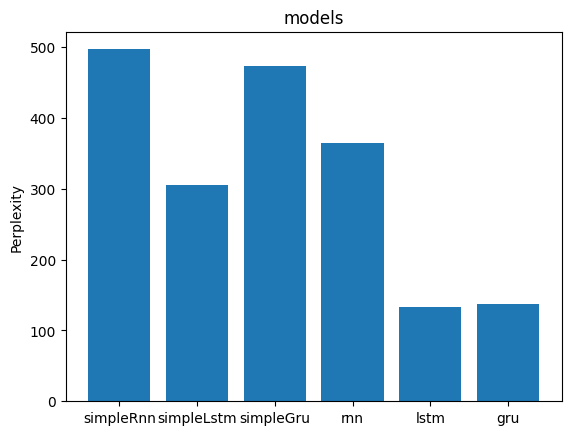

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

models_names = ['simpleRnn', 'simpleLstm', 'simpleGru','rnn', 'lstm', 'gru']

ax.bar(models_names, counts)

ax.set_ylabel('Perplexity')
ax.set_title('models')

plt.show()

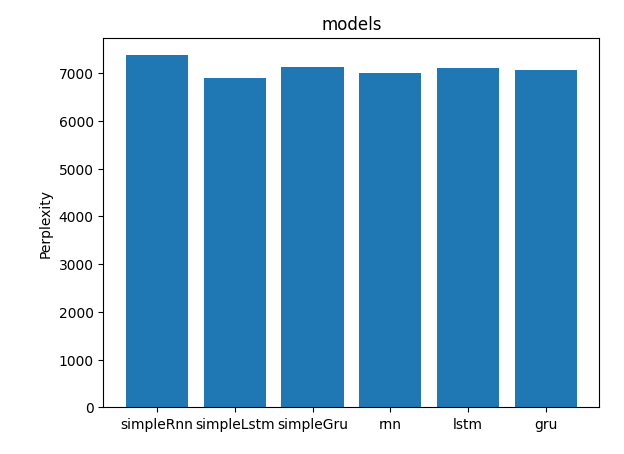

In [28]:
for i in range(30):
    for model in models:
        for word in predict(dataset, model, text='Knock knock. Whos there?'):
            print(word, end = ' ')
        print()
    print()

Knock knock. Whos there? Nomads! hate they play nut? vegetable Buffalo Astana-shing peas! an 
Knock knock. Whos there? glass babies! terrible poop midget soldier later. mathematician cats, grayvy. 
Knock knock. Whos there? Kellog's link chickens were no Soup God." hole board ears? 
Knock knock. Whos there? worker model organize a tells heavier Which they with bitter 
Knock knock. Whos there? halos... myself cut when the can are a watering A 
Knock knock. Whos there? cables? fight? Howls con-artist that... Cinderella in A cross read 

Knock knock. Whos there? share pickle. who call "A" tiers. ...all Lama female wings? 
Knock knock. Whos there? mode affect gonna my "Elementary, asked ribbit!!](https://www.youtube.com/watch?v=CYkDxsaHlkg) daddy was flowers, 
Knock knock. Whos there? 'What's scary?! Bangladesh? pearl? A spilled bambooboo. arguing, Elsa knew 
Knock knock. Whos there? now! it!!! to the nails *Come the licked to no 
Knock knock. Whos there? tree body you a medal... other book

Knock knock. Whos there? teller warranted. freshener whey. amoosing. hoes uses I'd 8? abcdefghijklmopqrstuvwxy 
Knock knock. Whos there? keep listen to Who beauty gig. Blue Baroque. sleeps Masahiro 
Knock knock. Whos there? trunk. a... 7up Saus O dropped socks? electron. French :D 
Knock knock. Whos there? burning friend in stationery. It'll Twisted guessed go! professional lighter. 
Knock knock. Whos there? wrong brick Check. :) make cat boring. hat you call 
Knock knock. Whos there? did put tell my my shopping Dam How He there 

Knock knock. Whos there? sink were Endor? bank legislation. Want I went real crocodile 
Knock knock. Whos there? Marion. sound Christmas! sewing cooler? American? I'll cables? cut interstate. 
Knock knock. Whos there? small Backgroud hairy in day... rabbits Porcel planets? eek" &amp; 
Knock knock. Whos there? South? hide service? from road? it about with a cake 
Knock knock. Whos there? the tie. cow Ba suits! took game Curses! pasta? sheep 
Knock knock. Whos 